In [1]:
import _nb_utils
%load_ext autoreload
%autoreload 2

In [2]:
from prompter import *
from data import *
from utils import *
from path import *
from config import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from functools import partial

import torch
import torchvision
from torchvision.models import segmentation as segmodels
from torchvision.models.mobilenetv3 import mobilenet_v3_large, MobileNet_V3_Large_Weights, MobileNetV3
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms as transforms
from torchvision.transforms._presets import SemanticSegmentation
import torch.nn.functional as F

# Model

In [4]:
print(torch.hub.get_dir())
print(CONFIG["device"])

/home/olivieri/exp/data/torch_weights
cuda


In [5]:
BY_MODEL = "LRASPP_MobileNet_V3"
SPLIT_BY = "non-splitted"
IMAGE_SIZE = 520

mask_prs_path = get_mask_prs_path(BY_MODEL)
mask_prs_path

PosixPath('/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/_mask_prs_')

In [ ]:
MODEL = segmodels.lraspp_mobilenet_v3_large(
    weights=None, # initialised decoder
    # weights=segmodels.LRASPP_MobileNet_V3_Large_Weights.DEFAULT, # pre-trained decoder
    weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V2 # pre-trained backbone
)
MODEL.to(CONFIG["device"])
MODEL.eval()

preprocess = partial(SemanticSegmentation, resize_size=IMAGE_SIZE)() # same as default transforms, but resize to 224 (instead of 520), as original backbone is trained on 224x224 ImageNet pictures.

# Data

# Inference

In [7]:
idxs = range(0, 10)
img_paths_to_upload = image_UIDs[idxs]

sc_list = [get_sc(SCS_PATH / (img_path + ".jpg"), IMAGE_SIZE, center_crop=True) for img_path in img_paths_to_upload]
gt_list = [get_gt(GTS_PATH / (img_path + ".png"), CLASS_MAP, IMAGE_SIZE, center_crop=True) for img_path in img_paths_to_upload]

In [8]:
# pr_list = [get_pr(get_mask_prs_path(BY_MODEL) / f"mask_pr_{i}.png", CLASS_MAP, 520, center_crop=True) for i, img_path in enumerate(img_paths_to_upload)]
# apply_colormap(pr_list[4], COLOR_MAP_DICT)

In [9]:
scs = torch.stack(sc_list, dim=0)
gts = torch.stack(gt_list, dim=0)
scs.shape, gts.shape

(torch.Size([10, 3, 520, 520]), torch.Size([10, 1, 520, 520]))

In [10]:
X = preprocess(scs)
logits = MODEL(X)["out"]
prs = logits.argmax(dim=1, keepdim=True).float()
assert scs.shape[2:] == gts.shape[2:] == prs.shape[2:]
prs.shape

torch.Size([10, 1, 520, 520])

In [11]:
gts_all_classes = (gts[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
prs_all_classes = (prs[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
assert prs_all_classes.shape == gts_all_classes.shape
gts_all_classes.shape

torch.Size([10, 21, 520, 520])

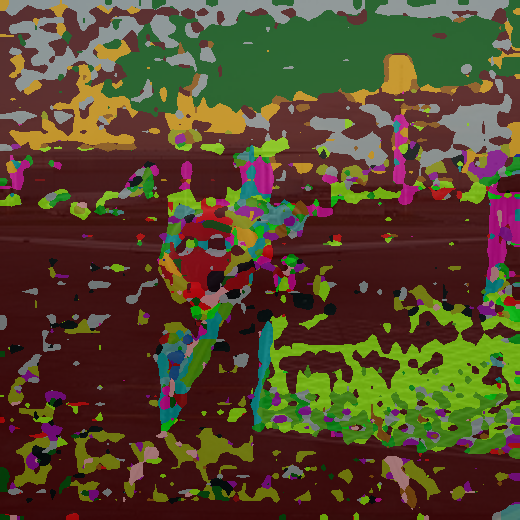

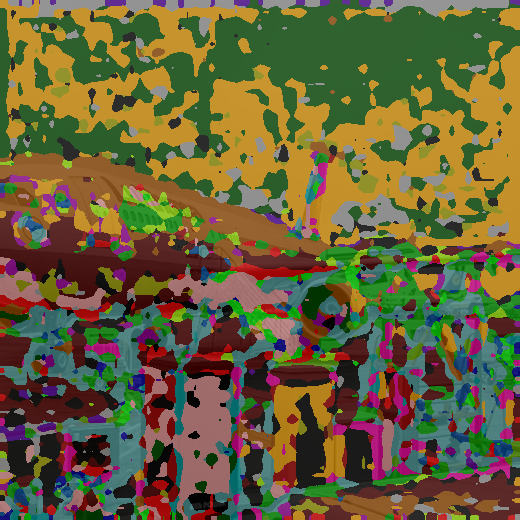

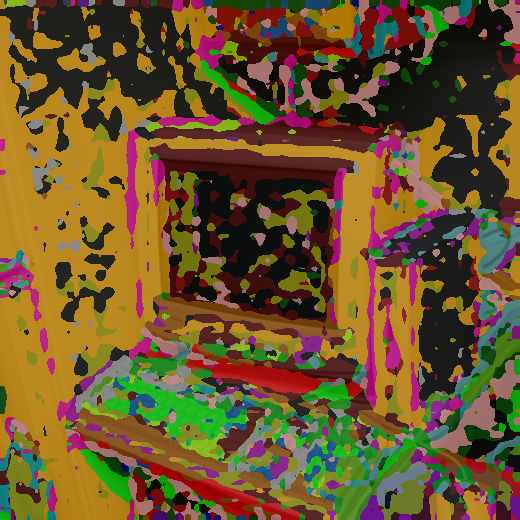

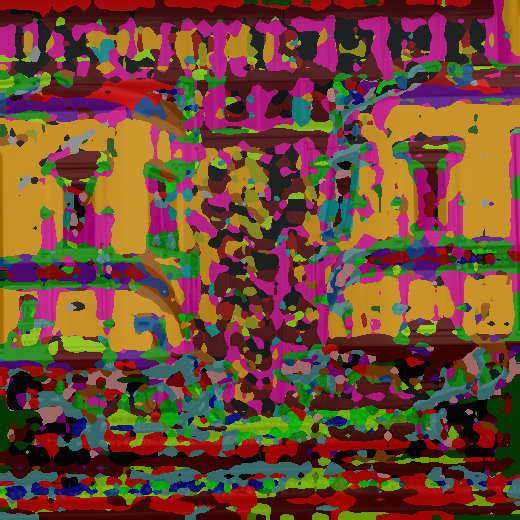

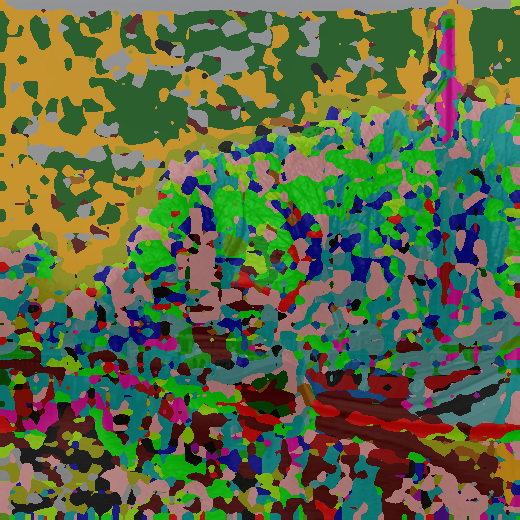

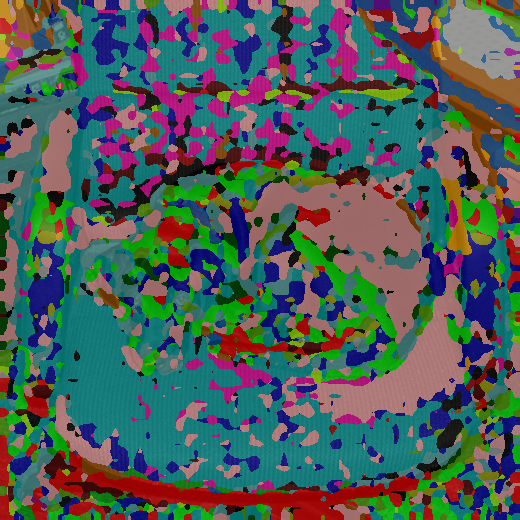

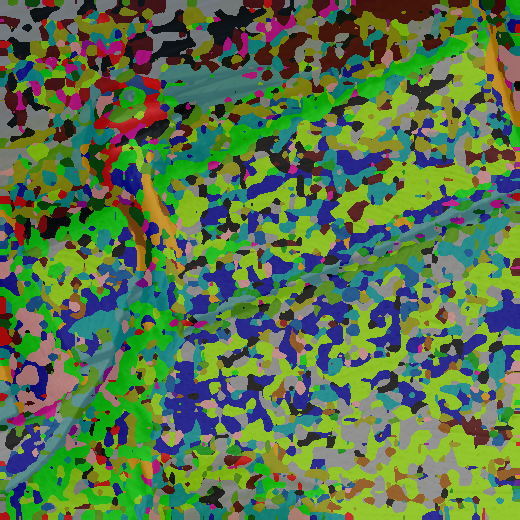

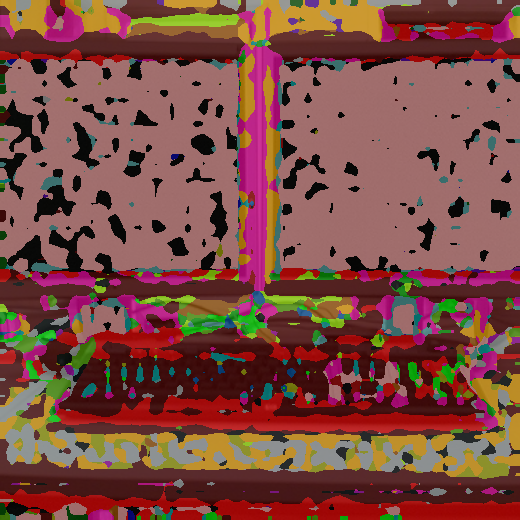

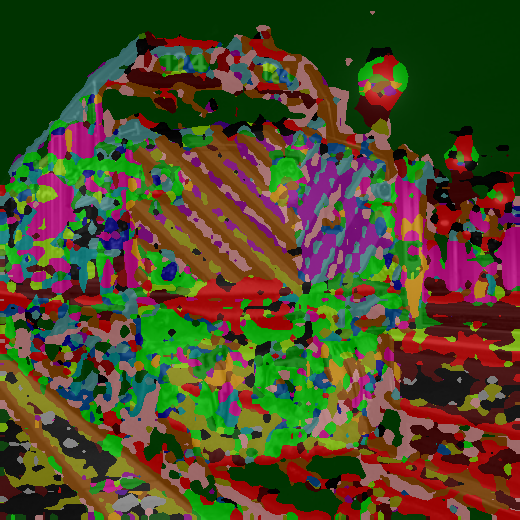

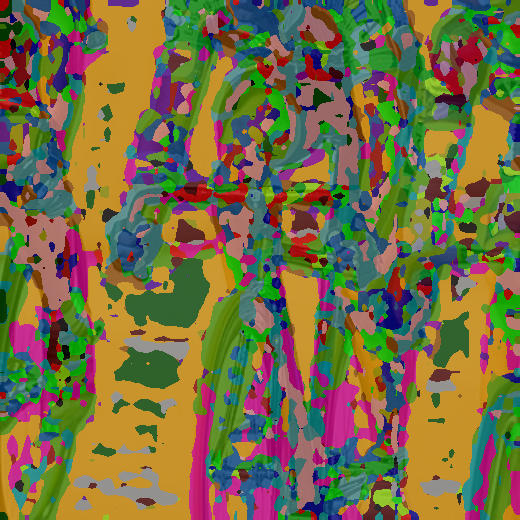

In [12]:
for i, idx in enumerate(idxs):
    pr_ovr = draw_segmentation_masks(scs[i], prs_all_classes[i], colors=list(COLOR_MAP_DICT.values()))
    display(to_pil_image(pr_ovr))
    # torchvision.utils.save_image(prs[i], mask_prs_path / f"mask_pr_{idx}.png", value_range=(0, 255), normalize=True)